# Model Training

Contents
- Process data into one-hot encoded sequence vectors and targets.
- Break into train, validation, and test sets.
- Perform a modest hyper-parameter search.
- Conclude that a variety of hyperparameters result in similar performance. (Actually interesting how similarly they perform.)
- Train and save a model to use in rest of analysis.

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [10]:
import sys
#sys.path.append('/home/dwkim/project/labranchor/')
#from labranchor.create_fasta import Genome
from genome import Genome
genome = Genome('/home/dwkim/gencode_v19_raw_data/labranchor.gencode_v19.fa')

In [11]:
key_make = [ item for item in range(880180-1, 880250+1)]
for k, v in genome.genome.items():
    if int(k.split(":")[1]) in key_make:
        print(k, v)

chr1:880179:- ATGAGTAACCTCTAAGGCTGGCTTCTTCCTGATAAAGCAAAATTTATGTAGCCTCCATCTCTCCCCGCAG


In [12]:
introns = {}
with open('/home/dwkim/anno/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        assert bp not in introns[key], bp
        if bp != -1: introns[key] += [bp]


In [13]:
# Used to compare to branchpointer
c = 0
with open('./test.tsv', 'w') as fp:
    ID = 0
    fp.write('\t'.join(['id', 'chromsome', 'start', 'end', 'strand']) + '\n')
    for (chrom, three, strand), bp in introns.items():
        if not bp or chrom != 'chr1':
            continue
        if strand == '+':
            begin, end = str(three - 70), str(three)
        else:
            c += 1
            begin, end = str(three+1), str(three + 70+1)
        
        fp.write('\t'.join(["chr1_{}_{}".format(three, strand),
                            'chr1', begin, end, strand]) + '\n')
print(c)

2145


In [14]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print(len(known))
print(len(missing))

37110
169182


In [18]:
L = 70
bases = ['A', 'C', 'G', 'T']

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

count =0 
X, y, chroms = [], [], []
for intron, bps in known.items():
    count+=1
    if count % 1000 == 0:
        print(count)
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    #print(seq)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    X += [onehot(seq).reshape(1, 70, 4)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]

X, y = np.vstack(X), np.vstack(y)
print(X.shape, y.shape, len(chroms))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
(37110, 70, 4) (37110, 70) 37110


In [31]:
### 
#test = np.array(map(lambda x: x == 'chr1', chroms))
#valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
#                     chroms))
test = np.array(list(map(lambda x: x == 'chr1', chroms)))
valid = np.array(list(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms)))

train = np.array([not (t or v) for t, v in zip(test, valid)])
print(sum(test),  sum(valid), sum(train))

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

4306 7093 25711
(25711, 70, 4) (7093, 70, 4) (4306, 70, 4)
(25711, 70) (7093, 70) (4306, 70)


In [32]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

# Compute PWM as sanity check

In [33]:
K = 3
counts = np.zeros((2*K+1, 4))
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1]
print(counts.T)

[[ 8658.  8037.  8984. 20929.  9468.  9994.  9281.]
 [12046.  8055. 11683.  6820. 11738. 11016. 10508.]
 [ 8100.  7269.  8965.  5728.  8041.  7817.  8519.]
 [10247. 15690.  9419.  5574.  9804. 10224. 10743.]]


# Model trainer

In [34]:
class ModelTrainer:
    def __init__(self, model):
        self.model = model
        self.train_auc = []
        self.train_match = []
        self.valid_auc = []
        self.valid_match = []
        
    def train(self, X_train, X_valid,
              y_train, y_valid, PATIENCE = 15, EPOCHS = 1000):
        print(model.summary())
        for i in range(EPOCHS):
            model.fit(X_train, y_train, epochs = 1, verbose = 0, batch_size = 8)
            self._evaluate(X_train, X_valid, y_train, y_valid)
            if (i > PATIENCE
                and max(self.valid_match[-PATIENCE:])
                < max(self.valid_match)):
                break
            print(i, self.valid_match[-1], self.train_match[-1])
        self._plot_scores()
        print(max(self.valid_match), max(self.valid_auc))
        model.save('./2layer.h5')
    
    def predict(X):
        return self.model.predict(X)
                
    def _evaluate(self, X_train, X_valid, y_train, y_valid):
        valid_preds = self.model.predict(X_valid, verbose=0)
        train_preds = self.model.predict(X_train, verbose=0)
        self.valid_match += [matching(valid_preds, y_valid)[0]
                             / float(y_valid.shape[0])]
        self.train_match += [matching(train_preds, y_train)[0]
                             / float(y_train.shape[0])]
        self.valid_auc += [metrics.roc_auc_score(y_valid.flatten(),
                                                 valid_preds.flatten())]
        self.train_auc += [metrics.roc_auc_score(y_train.flatten(),
                                                 train_preds.flatten())]
    
    def _plot_scores(self):
        plt.plot(self.valid_match, label = 'Validation')
        plt.plot(self.train_match, label = 'Training')
        plt.ylabel('Match')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        
        plt.plot(self.valid_auc, label = 'Validation')
        plt.plot(self.train_auc, label = 'Training')
        plt.ylabel('auROC')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

In [35]:
"""
from keras.models import Sequential
from keras.layers import Dense, Reshape, LSTM, Dropout
from keras.layers.convolutional import Conv2D
from keras import regularizers
from keras import optimizers
from keras.layers.wrappers import Bidirectional, TimeDistributed"""

'\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Reshape, LSTM, Dropout\nfrom keras.layers.convolutional import Conv2D\nfrom keras import regularizers\nfrom keras import optimizers\nfrom keras.layers.wrappers import Bidirectional, TimeDistributed'

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, LSTM, Dropout, Reshape
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras import regularizers, optimizers

# Model all figs are based on

2021-11-16 00:32:50.734228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-16 00:32:50.761728: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3693100000 Hz
2021-11-16 00:32:50.764354: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558cbd78ebc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-16 00:32:50.764376: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Please use `model.predict()` instead.
0 0.3158043141125053 0.33129788806347477
1 0.3504863950373608 0.367080238030415
2 0.36289299309178064 0.37940959122554546
3 0.37078810094459325 0.3876550892614056
4 0.3798110813478077 0.3933724864843841
5 0.38559142816861697 0.3995177161526195
6 0.4034964049062456 0.41810898059196455
7 0.4060341181446497 0.4263

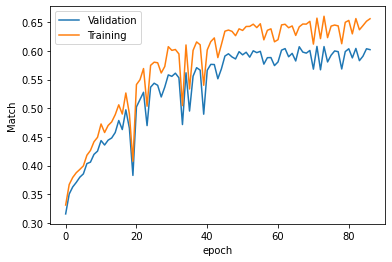

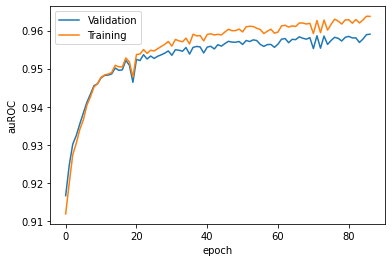

0.6077823205977725 0.959053649917582


In [37]:
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train[:, :, :4], X_valid[:, :, :4],
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [39]:
model.save('./2layer.h5')

In [43]:
from tensorflow.keras.models import load_model
new_model = load_model('./2layer.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________


In [44]:
ModelTrainer(new_model).train(X_train[:, :, :4], X_valid[:, :, :4],
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None


KeyboardInterrupt: 

# Hyper param search

- In summary all of the models did about the same
- Maybe slight advantage to deeper models, but if two layers is good enough, I'm inclined to stay simple.

In [ ]:
num_layers = [4, 3, 2, 1]
l2s = [0]
hiddens = [32, 24]
lrs = [0.001]
dropouts = [0.15, 0.1, 0.2]
r_dropouts = [0.05]

for l2 in l2s:
    for hidden in hiddens:
        for lr in lrs:
            for dropout in dropouts:
                for r_dropout in r_dropouts:
                    for num_layer in num_layers:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(l2)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                     dropout = dropout, recurrent_dropout = r_dropout),
                                                     input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                           dropout = dropout, recurrent_dropout = r_dropout)))

                        model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [ ]:
# Why not?
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))